# Wine Quality Risk Framework  
## Early Warning under Delayed Feedback Conditions

This notebook converts scenario simulation outputs into a deterministic risk score and actionable risk segments.

We define “risk” as the likelihood and magnitude of quality loss under plausible chemical deviations, before delayed market feedback becomes visible.



In [1]:
import pandas as pd
import numpy as np
from pathlib import Path


## Load simulation outputs

We reuse the outputs generated in `04_scenario_simulation.ipynb`:

- `scenario_sensitivity_results.csv`: detailed scenario runs (feature, delta, predicted quality)
- `scenario_leverage_table.csv`: summary leverage ranking (±10% impact)

These files are treated as the source of truth for the risk framework.


In [4]:
DATA_PATH = Path("../data/processed")

sens_path = DATA_PATH / "scenario_sensitivity_results.csv"
lev_path = DATA_PATH / "scenario_leverage_table.csv"

sensitivity_results = pd.read_csv(sens_path)
leverage_table = pd.read_csv(lev_path)

sensitivity_results.head(), leverage_table.head()


(            feature  delta_pct  feature_value  pred_quality  delta_quality
 0  volatile acidity      -20.0       0.415597      5.853031       0.117499
 1  volatile acidity      -10.0       0.467547      5.794281       0.058750
 2  volatile acidity       -5.0       0.493521      5.764907       0.029375
 3  volatile acidity        0.0       0.519496      5.735532       0.000000
 4  volatile acidity        5.0       0.545471      5.706157      -0.029375,
                 feature  delta_quality_-10pct  delta_quality_+10pct  \
 0                    pH              0.129810             -0.129810   
 1      volatile acidity              0.058750             -0.058750   
 2         fixed acidity             -0.021653              0.021653   
 3  total sulfur dioxide              0.009972             -0.009972   
 4        residual sugar             -0.003457              0.003457   
 
    abs_max_impact_10pct  
 0              0.129810  
 1              0.058750  
 2              0.021653  
 

## Baseline quality reference

The scenario simulation outputs include `delta_quality`, computed relative to the baseline predicted quality.
We reconstruct the baseline predicted quality using the fact that:

delta_quality = pred_quality - baseline_pred_quality

So baseline_pred_quality = pred_quality - delta_quality (constant across all rows).


In [5]:
baseline_pred_quality = (sensitivity_results["pred_quality"] - sensitivity_results["delta_quality"]).iloc[0]
baseline_pred_quality


np.float64(5.735531830082987)

## Deterministic Risk Score (definition)

We define risk as “downside exposure” under plausible parameter deviations.

For each feature, we consider a ±10% perturbation (business-reasonable small drift).
We extract the predicted quality drop at:
- -10% change
- +10% change

We keep only downside impact (quality decreases), and aggregate across features.

Risk score (raw) = sum over features of max(0, -delta_quality_at_±10%)

This yields a single score where:
- 0 means no downside sensitivity at ±10% changes
- higher values indicate greater vulnerability to small deviations


In [6]:
# Keep only the +/-10% rows
sens_10 = sensitivity_results[sensitivity_results["delta_pct"].isin([-10, 10])].copy()

# Pivot: one row per feature, columns = -10 and +10 delta_quality
pivot = sens_10.pivot_table(
    index="feature",
    columns="delta_pct",
    values="delta_quality",
    aggfunc="mean"
).rename(columns={-10: "delta_q_-10", 10: "delta_q_+10"})

# Downside only (drops in quality are negative delta_quality)
pivot["downside_-10"] = np.maximum(0, -pivot["delta_q_-10"])
pivot["downside_+10"] = np.maximum(0, -pivot["delta_q_+10"])

# Conservative downside for the feature: worst of the two directions
pivot["feature_downside"] = pivot[["downside_-10", "downside_+10"]].max(axis=1)

pivot.sort_values("feature_downside", ascending=False)


delta_pct,delta_q_-10,delta_q_+10,downside_-10,downside_+10,feature_downside
feature,,,,,
pH,0.129810,-0.129810,0.000000,0.129810,0.129810
volatile acidity,0.058750,-0.058750,0.000000,0.058750,0.058750
fixed acidity,-0.021653,0.021653,0.021653,0.000000,0.021653
total sulfur dioxide,0.009972,-0.009972,0.000000,0.009972,0.009972
residual sugar,-0.003457,0.003457,0.003457,0.000000,0.003457
free sulfur dioxide,-0.003159,0.003159,0.003159,0.000000,0.003159


## Risk score summary

We compute:
- total downside risk score (sum of feature downsides)
- contribution share per feature (to identify key risk drivers)

This turns simulations into a decision-ready, explainable risk metric.


In [7]:
total_risk_score = pivot["feature_downside"].sum()

pivot["contribution_pct"] = (pivot["feature_downside"] / total_risk_score) * 100 if total_risk_score > 0 else 0
pivot_sorted = pivot.sort_values("feature_downside", ascending=False)

total_risk_score, pivot_sorted


(np.float64(0.2268015170667456),
 delta_pct             delta_q_-10  delta_q_+10  downside_-10  downside_+10  \
 feature                                                                      
 pH                       0.129810    -0.129810      0.000000      0.129810   
 volatile acidity         0.058750    -0.058750      0.000000      0.058750   
 fixed acidity           -0.021653     0.021653      0.021653      0.000000   
 total sulfur dioxide     0.009972    -0.009972      0.000000      0.009972   
 residual sugar          -0.003457     0.003457      0.003457      0.000000   
 free sulfur dioxide     -0.003159     0.003159      0.003159      0.000000   
 
 delta_pct             feature_downside  contribution_pct  
 feature                                                   
 pH                            0.129810         57.235103  
 volatile acidity              0.058750         25.903534  
 fixed acidity                 0.021653          9.547047  
 total sulfur dioxide          0.

## Risk segmentation (Low / Medium / High)

To make the score actionable, we convert the continuous risk score into segments.

Because this is a deterministic baseline-driven score (not per-wine yet),
we define segments using quantiles once we compute per-wine risk scores.

Next, we will compute a per-wine risk score by simulating small perturbations around each wine profile.
For now, we define the segmentation method:

- Low Risk: bottom 33% of scores
- Medium Risk: middle 33%
- High Risk: top 33%

This approach is transparent and dataset-driven.


## Per-wine risk scoring (10–12% baseline regime)

So far, we quantified feature-level downside sensitivity around the baseline profile.

Now we operationalize the framework at the wine level:
- We select wines from the stable 10–12% alcohol segment.
- For each wine, we apply ±10% perturbations to each risk feature (one-at-a-time).
- We predict quality under each perturbation using the same alcohol-aware model.
- We compute downside risk per feature as the worst quality drop among ±10%.
- The per-wine risk score is the sum of feature downsides.

This produces a decision-ready risk score distribution and enables segmentation.


In [8]:
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]

wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)

# Drop irrelevant identifier
wine_quality = wine_quality.drop(columns=["Id"], errors="ignore")

# Create alcohol_segment_3 (required for alcohol-aware modeling)
wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)

wine_quality["alcohol_segment_3"].value_counts()


alcohol_segment_3
10–12%    536
<10%      485
>12%      122
Name: count, dtype: int64

## Train the alcohol-aware quality model (reproducible)

Per-wine simulation requires a trained model that maps chemical inputs to predicted quality.
We rebuild the alcohol-aware global model (Ridge + standardization) to ensure reproducibility.


In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Build X/y
y = wine_quality["quality"]
X = wine_quality.drop(columns=["quality"], errors="ignore").copy()

# Add alcohol regime indicator (categorical)
X["alcohol_segment"] = wine_quality["alcohol_segment_3"]

# One-hot encode and train
X = pd.get_dummies(X, drop_first=True)

quality_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

quality_model.fit(X, y)

# Quick CV sanity check (optional)
rmse_cv = -cross_val_score(
    quality_model, X, y,
    scoring="neg_root_mean_squared_error",
    cv=5
).mean()

r2_cv = cross_val_score(
    quality_model, X, y,
    scoring="r2",
    cv=5
).mean()

rmse_cv, r2_cv


(np.float64(0.6537256276130197), np.float64(0.3091840998752754))

## Risk features and perturbation rule

We compute per-wine risk using the same ±10% one-at-a-time perturbations used in the scenario step.

Risk features:
- pH
- volatile acidity
- fixed acidity
- total sulfur dioxide
- free sulfur dioxide
- residual sugar

For each feature:
- simulate -10% and +10%
- compute downside = max(0, -(predicted_delta_quality))
- keep the worst downside between the two directions


In [10]:
risk_features = [
    "pH",
    "volatile acidity",
    "fixed acidity",
    "total sulfur dioxide",
    "free sulfur dioxide",
    "residual sugar"
]

delta_options = [-0.10, 0.10]


## Compute per-wine risk score

For each wine in the 10–12% segment:
1) predict baseline quality
2) apply ±10% to each risk feature
3) predict quality under each perturbation
4) compute the downside drop per feature
5) sum downsides into a per-wine risk score

This yields:
- `risk_score` per wine
- feature-level contributions per wine (for explainability)


In [11]:
# Focus on the baseline regime wines (10–12%)
wines_base = wine_quality[wine_quality["alcohol_segment_3"] == "10–12%"].copy()
wines_base = wines_base.reset_index(drop=True)

def build_model_input(df_row: pd.DataFrame) -> pd.DataFrame:
    """Transform a single-row dataframe into the same feature space as X."""
    X_row = df_row.drop(columns=["quality"], errors="ignore").copy()
    X_row["alcohol_segment"] = df_row["alcohol_segment_3"]
    X_row = X_row.drop(columns=["alcohol_segment_3"], errors="ignore")
    X_row = pd.get_dummies(X_row, drop_first=True)
    return X_row.reindex(columns=X.columns, fill_value=0)

risk_records = []

for i in range(len(wines_base)):
    row = wines_base.loc[i].copy()

    # Baseline prediction for this wine
    df0 = pd.DataFrame([row])
    X0 = build_model_input(df0)
    pred0 = quality_model.predict(X0)[0]

    # Track per-feature downside
    feature_downsides = {}
    
    for feat in risk_features:
        downsides = []
        
        for d in delta_options:
            row_cf = row.copy()
            row_cf[feat] = row_cf[feat] * (1 + d)
            
            df_cf = pd.DataFrame([row_cf])
            X_cf = build_model_input(df_cf)
            pred_cf = quality_model.predict(X_cf)[0]
            
            delta_q = pred_cf - pred0  # per-wine delta
            downside = max(0, -delta_q)  # keep only drops
            downsides.append(downside)
        
        feature_downsides[feat] = max(downsides)  # worst-case downside at ±10%
    
    risk_score = sum(feature_downsides.values())
    
    rec = {"wine_index": i, "pred_quality_baseline": pred0, "risk_score": risk_score}
    rec.update({f"downside_{k}": v for k, v in feature_downsides.items()})
    risk_records.append(rec)

risk_df = pd.DataFrame(risk_records)
risk_df.head()


,wine_index,pred_quality_baseline,risk_score,downside_pH,downside_volatile acidity,downside_fixed acidity,downside_total sulfur dioxide,downside_free sulfur dioxide,downside_residual sugar
0,0,5.303389,0.234986,0.132363,0.073508,0.018846,0.005482,0.003125,0.001661
1,1,5.815399,0.219131,0.128849,0.031665,0.021944,0.026889,0.007292,0.002492
2,2,5.147010,0.252705,0.130802,0.076335,0.017297,0.021406,0.003542,0.003323
3,3,5.556286,0.229389,0.133535,0.067854,0.020137,0.003916,0.000625,0.003323
4,4,5.740679,0.233137,0.130021,0.050890,0.018846,0.022712,0.002500,0.008168


## Risk score distribution and segmentation

We convert the continuous per-wine risk score into decision-ready segments using tertiles:
- Low Risk: bottom 33%
- Medium Risk: middle 33%
- High Risk: top 33%

This is transparent, dataset-driven, and easy to explain to stakeholders.


In [12]:
# Tertile thresholds
q1 = risk_df["risk_score"].quantile(0.33)
q2 = risk_df["risk_score"].quantile(0.66)

def segment(score):
    if score <= q1:
        return "Low Risk"
    elif score <= q2:
        return "Medium Risk"
    else:
        return "High Risk"

risk_df["risk_segment"] = risk_df["risk_score"].apply(segment)

risk_df["risk_segment"].value_counts()


risk_segment
High Risk      182
Medium Risk    177
Low Risk       177
Name: count, dtype: int64

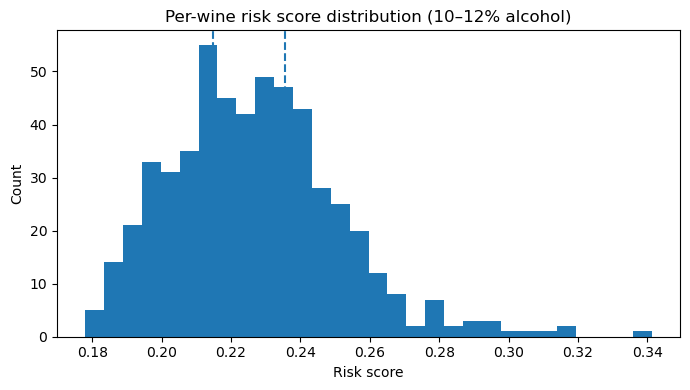

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(risk_df["risk_score"], bins=30)
plt.axvline(q1, linestyle="--")
plt.axvline(q2, linestyle="--")
plt.title("Per-wine risk score distribution (10–12% alcohol)")
plt.xlabel("Risk score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Explainability: top risk drivers by segment

To make the framework actionable, we summarize which features contribute most to risk
within each segment (Low/Medium/High).


In [15]:
driver_cols = [f"downside_{f}" for f in risk_features]

segment_driver_summary = (
    risk_df.groupby("risk_segment")[driver_cols]
    .mean()
    .T
)

segment_driver_summary


risk_segment,High Risk,Low Risk,Medium Risk
downside_pH,0.132179,0.127583,0.129601
downside_volatile acidity,0.081353,0.038048,0.056209
downside_fixed acidity,0.020066,0.023132,0.021806
downside_total sulfur dioxide,0.012271,0.007253,0.010327
downside_free sulfur dioxide,0.003648,0.002378,0.003439
downside_residual sugar,0.003731,0.003247,0.003386


In [16]:
for seg in ["Low Risk", "Medium Risk", "High Risk"]:
    top = segment_driver_summary[seg].sort_values(ascending=False).head(3)
    print(f"{seg} — top drivers:")
    for k, v in top.items():
        print(f"  - {k.replace('downside_', '')}: {v:.4f}")
    print()


Low Risk — top drivers:
  - pH: 0.1276
  - volatile acidity: 0.0380
  - fixed acidity: 0.0231

Medium Risk — top drivers:
  - pH: 0.1296
  - volatile acidity: 0.0562
  - fixed acidity: 0.0218

High Risk — top drivers:
  - pH: 0.1322
  - volatile acidity: 0.0814
  - fixed acidity: 0.0201

